# SNARE: Suspicious Network Apartment Rental Evaluator
## Unsupervised Anomaly Detection for Fraudulent Rental Listings

**Project Overview:**
This notebook implements an anomaly detection system to identify potentially fraudulent apartment listings from rental platforms like Craigslist. Using multiple unsupervised machine learning techniques, we aim to protect renters from scams that cost victims $500-$2000+ in deposits and relocation expenses.

In [1]:
%pwd
%cd "/Users/annubaka/Library/Mobile Documents/com~apple~CloudDocs/Projects/Python/Personal/SNARE"
%pwd

/Users/annubaka/Library/Mobile Documents/com~apple~CloudDocs/Projects/Python/Personal/SNARE


/Users/annubaka/Library/Mobile Documents/com~apple~CloudDocs/Projects/Python/Personal/SNARE/.venv/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


'/Users/annubaka/Library/Mobile Documents/com~apple~CloudDocs/Projects/Python/Personal/SNARE'

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from db.database_setup import ListingsDatabase

pd.set_option('display.max_colwidth', 50)
pd.set_option('display.max_columns', None)



The problem in question: 
Innocent renters are routinely misled by fraudulent apartment listings. This results in financial loss, wasted time, and eroded trust in rental platforms. We want to detect these listings before users interact with them.

Why is this an issue:
Fake listings can cost a user $500–$2000 in deposits, cause major relocation delays, and damage the credibility of rental platforms like Craigslist or Facebook Marketplace.

Because ground truth labels are rarely available, most scams are only identified after the fact, if at all. So, we treat this as an unsupervised anomaly detection problem.

We hypothesize that fraudulent listings deviate from legitimate ones in terms of price, language, location patterns, and posting frequency. Our goal is to surface statistically significant outliers that exhibit these deviations.

We aim to explore which dimensions (e.g. price per square foot, language style, closeness to vulnerable locations) contribute most strongly to listings being flagged as anomalies.

What behavioral or structural patterns recur across flagged anomalies? Are there repeat tactics that align with known scam indicators?

Goal:
Develop an unsupervised anomaly detection system that flags suspicious apartment listings based on price anomalies, language cues, metadata inconsistencies, and location density deviations.

Why it matters:
Early detection reduces scam exposure, protects users, and enhances platform trust. The ability to flag potential scams can also assist human moderators or serve as a triage layer.

# Data Loading & Preprocessing
## Cleaning and Preparing Craigslist Rental Data

In [3]:
# load the dataset from the database
db = ListingsDatabase("data/listings.db")
listings = db.get_listings(source='craigslist')

df = pd.DataFrame(listings)
df = df.drop(['id', 'created_at', 'updated_at'], axis=1, errors='ignore')

print(f"Loaded {len(df)} listings")
df.head(3)

✓ Database initialized successfully
Loaded 2116 listings


,listing_id,source,listing_name,price,address,city,state,postal_code,latitude,longitude,bedrooms,bathrooms,square_footage,time_posted,description,phone_number,url
0,7866648729,craigslist,"Bark Park, Outdoor Kitchen, Racquetball Court",1259.0,10023 Belle Rive Blvd.,Jacksonville,FL,32256,30.2214,-81.5571,1.0,1.0,675.0,2025-07-18 10:23:15-04:00,QR Code Link to This Post\n\n\n10023 Belle Riv...,7866648729,https://jacksonville.craigslist.org/apa/d/jack...
1,7854062085,craigslist,REDUCED PRICING! 3 Bedroom 2 Bathroom Apartmen...,1950.0,9000 Colby Drive,Fort Myers,FL,33919,26.5567,-81.9034,3.0,2.0,1330.0,2025-05-29 13:01:10-04:00,QR Code Link to This Post\n\n\nResidential Com...,7854062085,https://fortmyers.craigslist.org/lee/apa/d/for...
2,7854061196,craigslist,Immediate Move In! 2 Bedroom 2 Bathroom Apartm...,1625.0,9000 Colby Drive,Fort Myers,FL,33919,26.5567,-81.9034,2.0,2.0,1202.0,2025-05-29 12:59:03-04:00,QR Code Link to This Post\n\n\nResidential Com...,7854061196,https://fortmyers.craigslist.org/lee/apa/d/for...


In [4]:
df.tail(3)

,listing_id,source,listing_name,price,address,city,state,postal_code,latitude,longitude,bedrooms,bathrooms,square_footage,time_posted,description,phone_number,url
2113,7841308442,craigslist,"⚡️FLASH SALE⚡️FREE APPLICATION,FREE ADMIN!LIMI...",1499.0,3924 Calibre Bend Lane,Winter Park,FL,32792,28.597400,-81.303600,1.0,1.0,966.0,2025-04-10 10:02:44-04:00,QR Code Link to This Post\n\n\n3924 Calibre Be...,7841308442,https://orlando.craigslist.org/apa/d/winter-pa...
2114,7841308464,craigslist,"Now Available, Washer and Dryer Option, Berber...",1805.0,11037 Laguna Bay Dr,Orlando,FL,32821,28.401057,-81.474197,2.0,2.0,903.0,2025-04-10 10:02:46-04:00,"QR Code Link to This Post\n\n\nWestwood Park, ...",7841308464,https://orlando.craigslist.org/apa/d/orlando-n...
2115,7841308548,craigslist,"Come Visit Today, Landscaped Grounds, Ceiling ...",1110.0,11037 Laguna Bay Dr,Orlando,FL,32821,28.401057,-81.474197,1.0,1.0,681.0,2025-04-10 10:03:06-04:00,QR Code Link to This Post\n\n\nWestwood Park A...,7841308548,https://orlando.craigslist.org/apa/d/orlando-c...


In [5]:
df.shape

(2116, 17)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2116 entries, 0 to 2115
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   listing_id      2116 non-null   object 
 1   source          2116 non-null   object 
 2   listing_name    2116 non-null   object 
 3   price           2110 non-null   float64
 4   address         2052 non-null   object 
 5   city            2052 non-null   object 
 6   state           2052 non-null   object 
 7   postal_code     2052 non-null   object 
 8   latitude        2116 non-null   float64
 9   longitude       2116 non-null   float64
 10  bedrooms        2025 non-null   float64
 11  bathrooms       2112 non-null   float64
 12  square_footage  1582 non-null   float64
 13  time_posted     2116 non-null   object 
 14  description     2116 non-null   object 
 15  phone_number    2116 non-null   object 
 16  url             2116 non-null   object 
dtypes: float64(6), object(11)
memory 

In [7]:
df.describe()

,price,latitude,longitude,bedrooms,bathrooms,square_footage
count,2110.000000,2116.000000,2116.000000,2025.000000,2112.000000,1582.000000
mean,1810.456398,27.918485,-82.274782,1.998025,1.612216,1062.644121
std,788.248019,1.516200,2.120926,0.891326,0.692863,406.130693
min,400.000000,25.603408,-87.685700,1.000000,1.000000,100.000000
25%,1340.000000,26.609803,-82.516300,1.000000,1.000000,800.000000
50%,1649.000000,27.775927,-81.765467,2.000000,2.000000,1046.000000
75%,2021.000000,28.627100,-80.640357,3.000000,2.000000,1247.000000
max,7550.000000,31.413700,-80.049975,5.000000,5.000000,3901.000000


In [8]:
df.isnull().sum() 

listing_id          0
source              0
listing_name        0
price               6
address            64
city               64
state              64
postal_code        64
latitude            0
longitude           0
bedrooms           91
bathrooms           4
square_footage    534
time_posted         0
description         0
phone_number        0
url                 0
dtype: int64

In [ ]:
# drop rows where price, bathroom is missing since they're so low 
df.dropna(axis= 0, subset = ['price','bathrooms'], inplace=True)
df.drop(columns='phone_number', inplace=True) 

In [10]:
# create a new column for whether the address is empty 
df['address_missing'] = df['address'].isnull() | df['address'].str.strip().eq('')

# do the same for city, state, postal_code
df['city_missing'] = df['city'].isnull() | df['city'].str.strip().eq('')
df['state_missing'] = df['state'].isnull() | df['state'].str.strip().eq('')
df['postal_code_missing'] = df['postal_code'].isnull() | df['postal_code'].str.strip().eq('')

# replace whitespace only strings with NaN since they may be missed by .fillna
df[['address', 'city', 'state', 'postal_code']] = df[['address', 'city', 'state', 'postal_code']].replace(r'^\s*$', np.nan, regex=True)

# fill NaNs with "Unknown"
df[['address', 'city', 'state', 'postal_code']] = df[['address', 'city', 'state', 'postal_code']].fillna("Unknown")

# add a new column for whether square_footage is missing
df['square_footage_missing'] = df['square_footage'].isnull() 

In [11]:
df['bedrooms'] = df['bedrooms'].fillna(0) # set rows with no bedroom to 0

In [12]:
df.info() # review the data types

<class 'pandas.core.frame.DataFrame'>
Index: 2106 entries, 0 to 2115
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   listing_id              2106 non-null   object 
 1   source                  2106 non-null   object 
 2   listing_name            2106 non-null   object 
 3   price                   2106 non-null   float64
 4   address                 2106 non-null   object 
 5   city                    2106 non-null   object 
 6   state                   2106 non-null   object 
 7   postal_code             2106 non-null   object 
 8   latitude                2106 non-null   float64
 9   longitude               2106 non-null   float64
 10  bedrooms                2106 non-null   float64
 11  bathrooms               2106 non-null   float64
 12  square_footage          1577 non-null   float64
 13  time_posted             2106 non-null   object 
 14  description             2106 non-null   objec

In [13]:
df.duplicated().sum() # find duplicates

np.int64(0)

In [14]:
df['state'].unique() # for sake of first model, lets focus on listings in florida

array(['FL', 'Unknown', 'AL'], dtype=object)

In [15]:
df = df[df['state'] != 'AL']


In [16]:
df['city'].unique() 

array(['Jacksonville', 'Fort Myers', 'Naples', 'Bonita Springs',
       'North Fort Myers', 'Cape Coral', 'Estero', 'Punta Gorda',
       'Port Charlotte', 'Rotonda West', 'Lehigh Acres', 'Unknown',
       'Fort Myers Beach', 'Alva', 'Bokeelia', 'Captiva', 'North Port',
       'Panama City', 'Panama City Beach', 'Lynn Haven', 'Bonifay',
       'Chipley', 'Altha', 'Sarasota', 'Ellenton', 'Bradenton', 'Venice',
       'Oneco', 'Parrish', 'Cortez', 'Myakka City', 'Apollo Beach',
       'Englewood', 'Palmetto', 'Nokomis', 'Laurel', 'Osprey', 'Ruskin',
       'Palm Bay', 'Melbourne', 'Titusville', 'Cocoa', 'Orlando',
       'Rockledge', 'Indialantic', 'Sharpes', 'Cocoa Beach', 'Malabar',
       'North Miami Beach', 'West Palm Beach', 'Hollywood',
       'Pompano Beach', 'Boynton Beach', 'Boca Raton', 'Hallandale',
       'Miami', 'Lake Worth', 'Fort Lauderdale', 'Jupiter',
       'Delray Beach', 'Opa Locka', 'Miami Beach', 'Pembroke Pines',
       'Deerfield Beach', 'Hialeah', 'Gainesville'

In [17]:
categorical_cols = ['source', 'state', 'city', 'postal_code']
for col in categorical_cols:
    df[col] = df[col].astype('category') # update the types of these columns to be categorical

# Feature Engineering
## Creating Scam Detection Features

We'll engineer features that capture potential fraud indicators:
- **Temporal patterns**: Unusual posting times that may indicate automated/bulk posting
- **Linguistic patterns**: Scam-related language, excessive caps/exclamations
- **Geographic patterns**: Distance from city centers, location clustering
- **Pricing patterns**: Price-to-square-foot ratios, duplicate listings with price variations
- **Metadata patterns**: Missing information, duplicate descriptions

In [18]:
# create features for datetime to identify potential patterns 
df['time_posted'] = pd.to_datetime(df['time_posted'], format='ISO8601', errors='raise', utc=True)

df['post_hour'] = df['time_posted'].dt.hour
df['post_dayofweek'] = df['time_posted'].dt.dayofweek  # 0 = Monday, 6 = Sunday
df['post_month'] = df['time_posted'].dt.month
df['post_weekday'] = df['time_posted'].dt.day_name()
df['post_weekday'] = df['post_weekday'].astype('category')
df['posted_at_night'] = df['post_hour'].apply(lambda x: x >= 0 and x <= 5)

In [100]:
df.isnull().sum()

listing_id                      0
source                          0
listing_name                    0
price                           0
address                         0
city                            0
state                           0
postal_code                     0
latitude                        0
longitude                       0
bedrooms                        0
bathrooms                       0
square_footage                528
time_posted                     0
description                     0
url                             0
address_missing                 0
city_missing                    0
state_missing                   0
postal_code_missing             0
square_footage_missing          0
post_hour                       0
post_dayofweek                  0
post_month                      0
post_weekday                    0
posted_at_night                 0
name_dup_count                  0
has_contact_info                0
num_exclamations                0
num_all_caps  

In [20]:
df.describe()

,price,latitude,longitude,bedrooms,bathrooms,square_footage,post_hour,post_dayofweek,post_month
count,2102.000000,2102.000000,2102.000000,2102.000000,2102.000000,1574.000000,2102.000000,2102.000000,2102.000000
mean,1813.341104,27.908778,-82.262104,1.912464,1.611323,1062.484752,14.485728,2.615604,4.714558
std,787.912403,1.511038,2.111360,0.961390,0.693154,405.753091,5.448258,1.641821,0.454882
min,400.000000,25.603408,-87.396200,0.000000,1.000000,100.000000,0.000000,0.000000,4.000000
25%,1349.000000,26.608011,-82.516300,1.000000,1.000000,800.000000,13.000000,1.000000,4.000000
50%,1649.000000,27.775927,-81.760600,2.000000,2.000000,1046.000000,15.000000,3.000000,5.000000
75%,2021.000000,28.627100,-80.640357,2.000000,2.000000,1247.000000,18.000000,4.000000,5.000000
max,7550.000000,30.988336,-80.049975,5.000000,5.000000,3901.000000,23.000000,6.000000,7.000000


In [21]:
df['name_dup_count'] = df.groupby('listing_name')['listing_name'].transform('count')
df['has_contact_info'] = df['description'].str.contains(r'\d{3}[-.\s]?\d{3}[-.\s]?\d{4}', regex=True)
df['num_exclamations'] = df['description'].str.count(r'!+')
df['num_all_caps'] = df['description'].str.findall(r'\b[A-Z]{2,}\b').str.len()
df['price_per_sqft'] = df['price'] / df['square_footage']
df['price_per_sqft'] = df['price_per_sqft'].replace([np.inf, -np.inf], np.nan)
df['price_per_sqft_missing'] = df['price_per_sqft'].isnull() 
df['bed_bath_ratio'] = df['bedrooms'] / df['bathrooms'].replace(0, np.nan)


In [22]:
from sklearn.cluster import DBSCAN
coords = df[['latitude', 'longitude']]
db_cl = DBSCAN(eps=0.01, min_samples=5).fit(coords)
df['location_cluster'] = db_cl.labels_
df['location_is_noise'] = df['location_cluster'] == -1


In [23]:
df['desc_clean'] = df['description'].str.lower().str.strip()
desc_counts = df['desc_clean'].value_counts()
df['desc_dup_count'] = df['desc_clean'].map(desc_counts)

desc_group = df.groupby('desc_clean')
df['price_std_in_desc'] = desc_group['price'].transform('std')
df['sqft_std_in_desc'] = desc_group['square_footage'].transform('std')

df['desc_mismatch_flag'] = (
    (df['desc_dup_count'] > 1) &
    (
        (df['price_std_in_desc'] > 200) | (df['sqft_std_in_desc'] > 100)
    )
)

df['desc_grouped'] = df['desc_dup_count'] > 1

In [24]:
scam_words = ['free', 'move in', 'no credit', 'immediate', 'must see', 'act now', 'cheap']

df['description_length'] = df['description'].str.len()
for word in scam_words:
    col_name = f'has_{word.replace(" ", "_")}'
    df[col_name] = df['desc_clean'].str.contains(word, regex=False, case=False)

df['num_scam_phrases'] = sum(
    df[f'has_{word.replace(" ", "_")}'] for word in scam_words
)

df['scam_phrase_density'] = df['num_scam_phrases'] / df['description_length']
df.drop(columns='desc_clean', axis=1, inplace=True)


In [25]:
city_centers = df.groupby('city')[['latitude', 'longitude']].mean()
df['city_lat'] = df['city'].map(city_centers['latitude'])
df['city_lon'] = df['city'].map(city_centers['longitude'])

from numpy import radians, sin, cos, sqrt, arctan2

def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
    return 2 * R * arctan2(sqrt(a), sqrt(1 - a))

df['distance_from_city_center'] = df.apply(lambda row: haversine(
    row['latitude'], row['longitude'], row['city_lat'], row['city_lon']), axis=1)

df['city_lat'] = df['city_lat'].astype(float)
df['city_lon'] = df['city_lon'].astype(float)


/var/folders/t5/ksv476hn4cq52bmfy8685cnh0000gn/T/ipykernel_63599/927681489.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  city_centers = df.groupby('city')[['latitude', 'longitude']].mean()


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2102 entries, 0 to 2115
Data columns (total 53 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   listing_id                 2102 non-null   object             
 1   source                     2102 non-null   category           
 2   listing_name               2102 non-null   object             
 3   price                      2102 non-null   float64            
 4   address                    2102 non-null   object             
 5   city                       2102 non-null   category           
 6   state                      2102 non-null   category           
 7   postal_code                2102 non-null   category           
 8   latitude                   2102 non-null   float64            
 9   longitude                  2102 non-null   float64            
 10  bedrooms                   2102 non-null   float64            
 11  bathrooms

In [27]:
df.describe()

,price,latitude,longitude,bedrooms,bathrooms,square_footage,post_hour,post_dayofweek,post_month,name_dup_count,num_exclamations,num_all_caps,price_per_sqft,bed_bath_ratio,location_cluster,desc_dup_count,price_std_in_desc,sqft_std_in_desc,description_length,num_scam_phrases,scam_phrase_density,city_lat,city_lon,distance_from_city_center
count,2102.000000,2102.000000,2102.000000,2102.000000,2102.000000,1574.000000,2102.000000,2102.000000,2102.000000,2102.000000,2102.000000,2102.000000,1574.000000,2102.000000,2102.000000,2102.000000,330.000000,226.000000,2102.000000,2102.000000,2102.000000,2102.000000,2102.000000,2102.000000
mean,1813.341104,27.908778,-82.262104,1.912464,1.611323,1062.484752,14.485728,2.615604,4.714558,2.087536,2.055186,9.801618,1.945808,1.201610,31.164129,1.741199,47.224065,26.576410,1361.496194,0.462417,0.000452,27.908778,-82.262104,6.453938
std,787.912403,1.511038,2.111360,0.961390,0.693154,405.753091,5.448258,1.641821,0.454882,4.309641,3.025011,22.599616,0.927943,0.485513,32.751690,2.636038,113.293069,58.878138,909.585564,0.651776,0.000980,1.507016,2.107264,16.590622
min,400.000000,25.603408,-87.396200,0.000000,1.000000,100.000000,0.000000,0.000000,4.000000,1.000000,0.000000,1.000000,0.417910,0.000000,-1.000000,1.000000,0.000000,0.000000,60.000000,0.000000,0.000000,25.699317,-87.325100,0.000000
25%,1349.000000,26.608011,-82.516300,1.000000,1.000000,800.000000,13.000000,1.000000,4.000000,1.000000,0.000000,2.000000,1.380000,1.000000,-1.000000,1.000000,0.000000,0.000000,630.500000,0.000000,0.000000,26.592624,-82.506319,1.891546
50%,1649.000000,27.775927,-81.760600,2.000000,2.000000,1046.000000,15.000000,3.000000,5.000000,1.000000,1.000000,4.000000,1.698386,1.000000,21.000000,1.000000,0.000000,0.000000,1138.000000,0.000000,0.000000,27.738713,-81.710277,4.174832
75%,2021.000000,28.627100,-80.640357,2.000000,2.000000,1247.000000,18.000000,4.000000,5.000000,1.000000,2.000000,7.000000,2.240072,1.500000,55.000000,1.000000,50.709255,3.535534,1804.000000,1.000000,0.000555,28.599965,-80.645505,8.061258
max,7550.000000,30.988336,-80.049975,5.000000,5.000000,3901.000000,23.000000,6.000000,7.000000,30.000000,19.000000,215.000000,12.362637,4.000000,102.000000,21.000000,883.883476,234.052345,4970.000000,3.000000,0.010870,30.980909,-80.086165,664.267978


# Exploratory Data Analysis (EDA)
## Understanding Data Distributions and Potential Anomaly Patterns

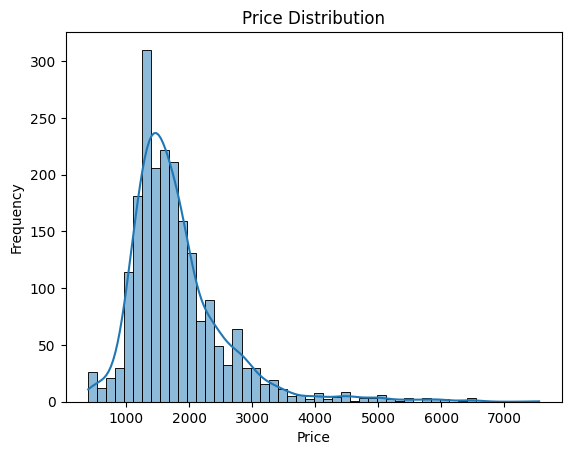

In [28]:
sns.histplot(df['price'], bins=50, kde=True)
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

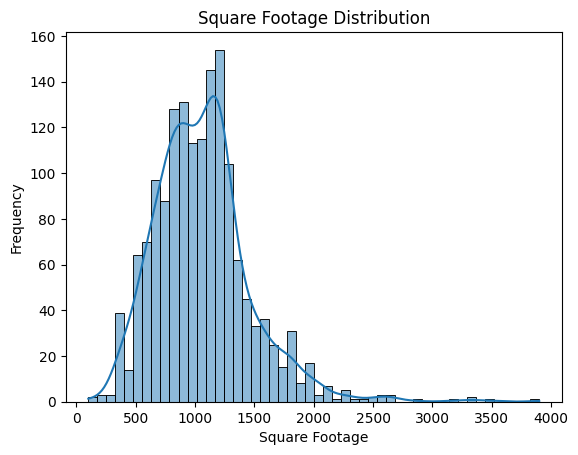

In [29]:
sns.histplot(df['square_footage'], bins=50, kde=True)
plt.title('Square Footage Distribution')
plt.xlabel('Square Footage')
plt.ylabel('Frequency')
plt.show()

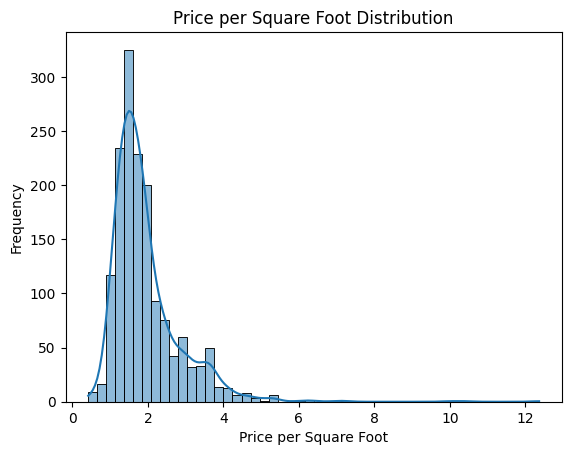

In [30]:
sns.histplot(df['price_per_sqft'], bins=50, kde=True)
plt.title('Price per Square Foot Distribution')
plt.xlabel('Price per Square Foot')
plt.ylabel('Frequency')
plt.show()

Text(0, 0.5, 'Frequency')

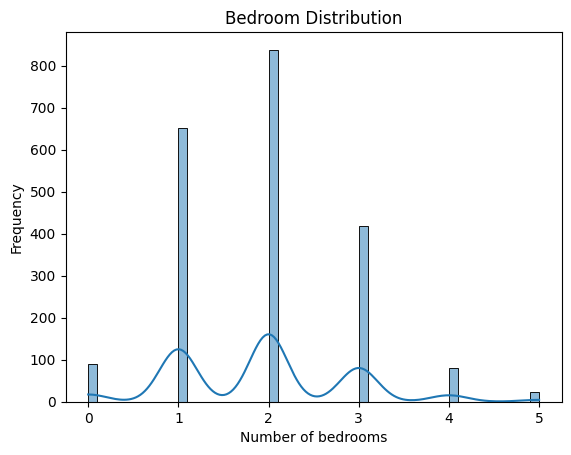

In [31]:
sns.histplot(df['bedrooms'], bins = 50, kde = True)
plt.title('Bedroom Distribution')
plt.xlabel('Number of bedrooms')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

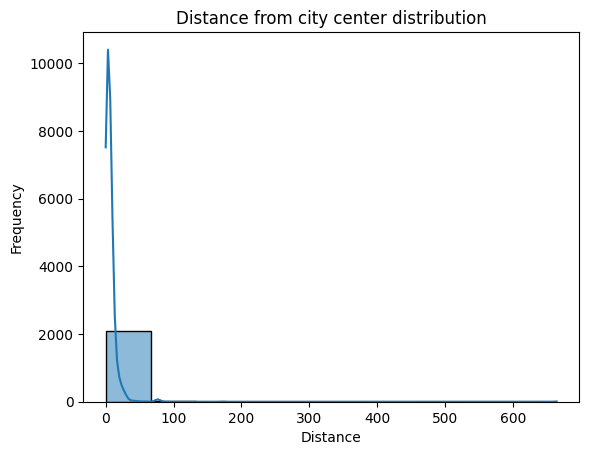

In [32]:
sns.histplot(df['distance_from_city_center'], bins = 10, kde=True)
plt.title('Distance from city center distribution')
plt.xlabel('Distance')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

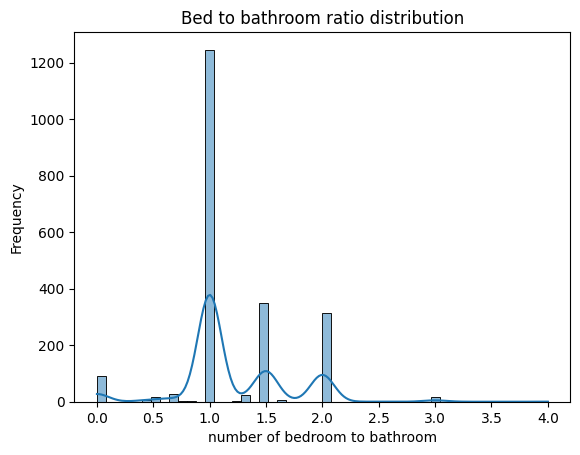

In [33]:
sns.histplot(df['bed_bath_ratio'], bins = 50, kde= True)
plt.title('Bed to bathroom ratio distribution')
plt.xlabel('number of bedroom to bathroom')
plt.ylabel('Frequency')

<Axes: xlabel='num_exclamations', ylabel='Count'>

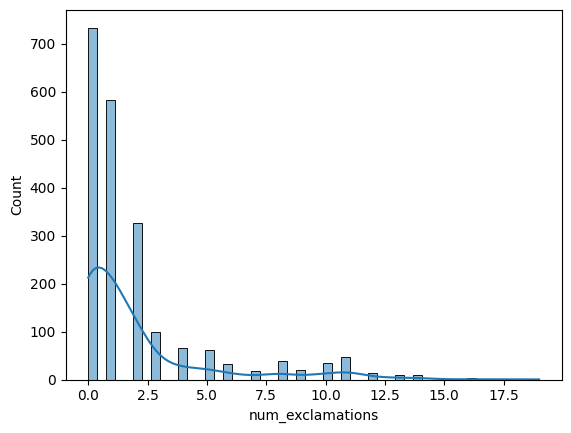

In [34]:
sns.histplot(df['num_exclamations'], bins = 50, kde=True)

<Axes: xlabel='num_all_caps', ylabel='Count'>

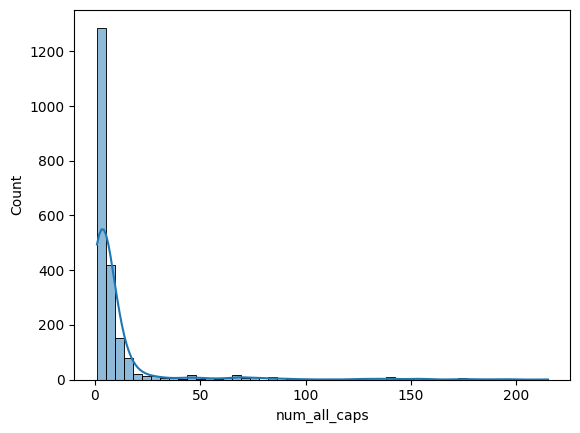

In [35]:
sns.histplot(df['num_all_caps'], bins = 50, kde=True)

<Axes: xlabel='num_scam_phrases', ylabel='Count'>

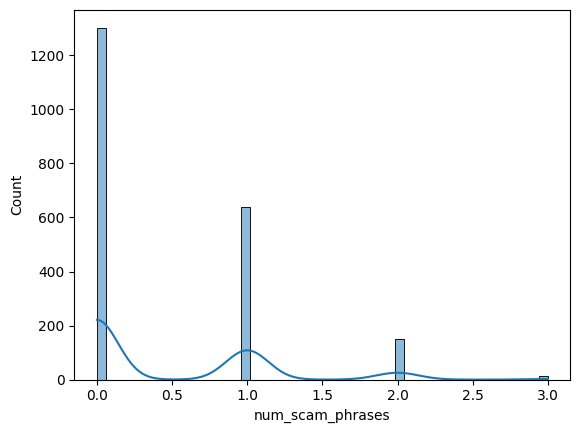

In [36]:
sns.histplot(df['num_scam_phrases'], bins = 50, kde=True)

<Axes: xlabel='desc_dup_count', ylabel='Count'>

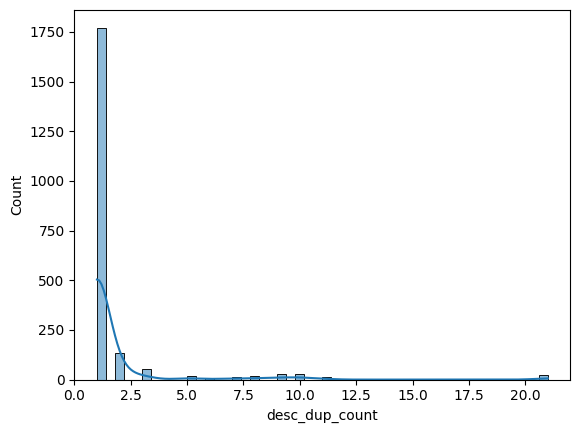

In [37]:
sns.histplot(df['desc_dup_count'], bins = 50, kde = True)

In [38]:
df['desc_dup_count'].unique()

array([ 1,  6,  2,  7,  3, 10,  5, 21,  9, 11,  8])

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2102 entries, 0 to 2115
Data columns (total 53 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   listing_id                 2102 non-null   object             
 1   source                     2102 non-null   category           
 2   listing_name               2102 non-null   object             
 3   price                      2102 non-null   float64            
 4   address                    2102 non-null   object             
 5   city                       2102 non-null   category           
 6   state                      2102 non-null   category           
 7   postal_code                2102 non-null   category           
 8   latitude                   2102 non-null   float64            
 9   longitude                  2102 non-null   float64            
 10  bedrooms                   2102 non-null   float64            
 11  bathrooms

In [40]:
categorical_cols = df.select_dtypes(include='category').columns

for col in categorical_cols:
    print(f"\n{col} value counts:")
    print(df[col].value_counts())



source value counts:
source
craigslist    2102
Name: count, dtype: int64

city value counts:
city
Sarasota       308
Orlando        164
Pensacola      149
Panama City    130
Miami          120
              ... 
Mount Dora       1
Plant City       1
Clearwater       1
Clarcona         1
Malabar          1
Name: count, Length: 121, dtype: int64

state value counts:
state
FL         2038
Unknown      64
Name: count, dtype: int64

postal_code value counts:
postal_code
32412      89
34243      68
Unknown    64
32514      62
34231      53
           ..
33434       1
32583       1
33445       1
33458       1
33185       1
Name: count, Length: 344, dtype: int64

post_weekday value counts:
post_weekday
Thursday     658
Wednesday    362
Monday       282
Tuesday      268
Friday       257
Saturday     146
Sunday       129
Name: count, dtype: int64


In [41]:
# drop risky or unhelpful features for unsupervised anomaly detection

# define feature groups to drop
drop_features = [
    # Identity / metadata
    'listing_id', 'url',
    
    # Redundant location info (used only for geo-processing, not modeling)
    'address', 'city', 'state', 'postal_code',
    'city_lat', 'city_lon',
    
    # Platform or data source bias
    'source',
    
    # Raw temporal metadata (too sparse or high-cardinality)
    'post_dayofweek', 'post_month', 'post_weekday', 'time_posted',
    
    # Linguistic booleans with low density and unclear impact
    'has_free', 'has_move_in', 'has_no_credit',
    'has_immediate', 'has_must_see',
    'has_act_now', 'has_cheap',

    # High cardinality text fields (unless you do NLP separately)
    'listing_name', 'description'
]

# Drop them from your DataFrame (assume df is your working DataFrame)
df_cleaned = df.drop(columns=[col for col in drop_features if col in df.columns])

print("Remaining features after pruning:")
print(df_cleaned.columns.tolist())


Remaining features after pruning:
['price', 'latitude', 'longitude', 'bedrooms', 'bathrooms', 'square_footage', 'address_missing', 'city_missing', 'state_missing', 'postal_code_missing', 'square_footage_missing', 'post_hour', 'posted_at_night', 'name_dup_count', 'has_contact_info', 'num_exclamations', 'num_all_caps', 'price_per_sqft', 'price_per_sqft_missing', 'bed_bath_ratio', 'location_cluster', 'location_is_noise', 'desc_dup_count', 'price_std_in_desc', 'sqft_std_in_desc', 'desc_mismatch_flag', 'desc_grouped', 'description_length', 'num_scam_phrases', 'scam_phrase_density', 'distance_from_city_center']


In [42]:
df_cleaned.head(3)

,price,latitude,longitude,bedrooms,bathrooms,square_footage,address_missing,city_missing,state_missing,postal_code_missing,square_footage_missing,post_hour,posted_at_night,name_dup_count,has_contact_info,num_exclamations,num_all_caps,price_per_sqft,price_per_sqft_missing,bed_bath_ratio,location_cluster,location_is_noise,desc_dup_count,price_std_in_desc,sqft_std_in_desc,desc_mismatch_flag,desc_grouped,description_length,num_scam_phrases,scam_phrase_density,distance_from_city_center
0,1259.0,30.2214,-81.5571,1.0,1.0,675.0,False,False,False,False,False,14,False,1,False,4,4,1.865185,False,1.0,-1,True,1,NaN,NaN,False,False,2658,1,0.000376,10.577115
1,1950.0,26.5567,-81.9034,3.0,2.0,1330.0,False,False,False,False,False,17,False,1,False,1,2,1.466165,False,1.5,0,False,6,188.911355,200.4761,True,True,1209,0,0.000000,6.422213
2,1625.0,26.5567,-81.9034,2.0,2.0,1202.0,False,False,False,False,False,16,False,1,False,1,2,1.351913,False,1.0,0,False,6,188.911355,200.4761,True,True,1209,0,0.000000,6.422213


In [43]:
df_cleaned.shape

(2102, 31)

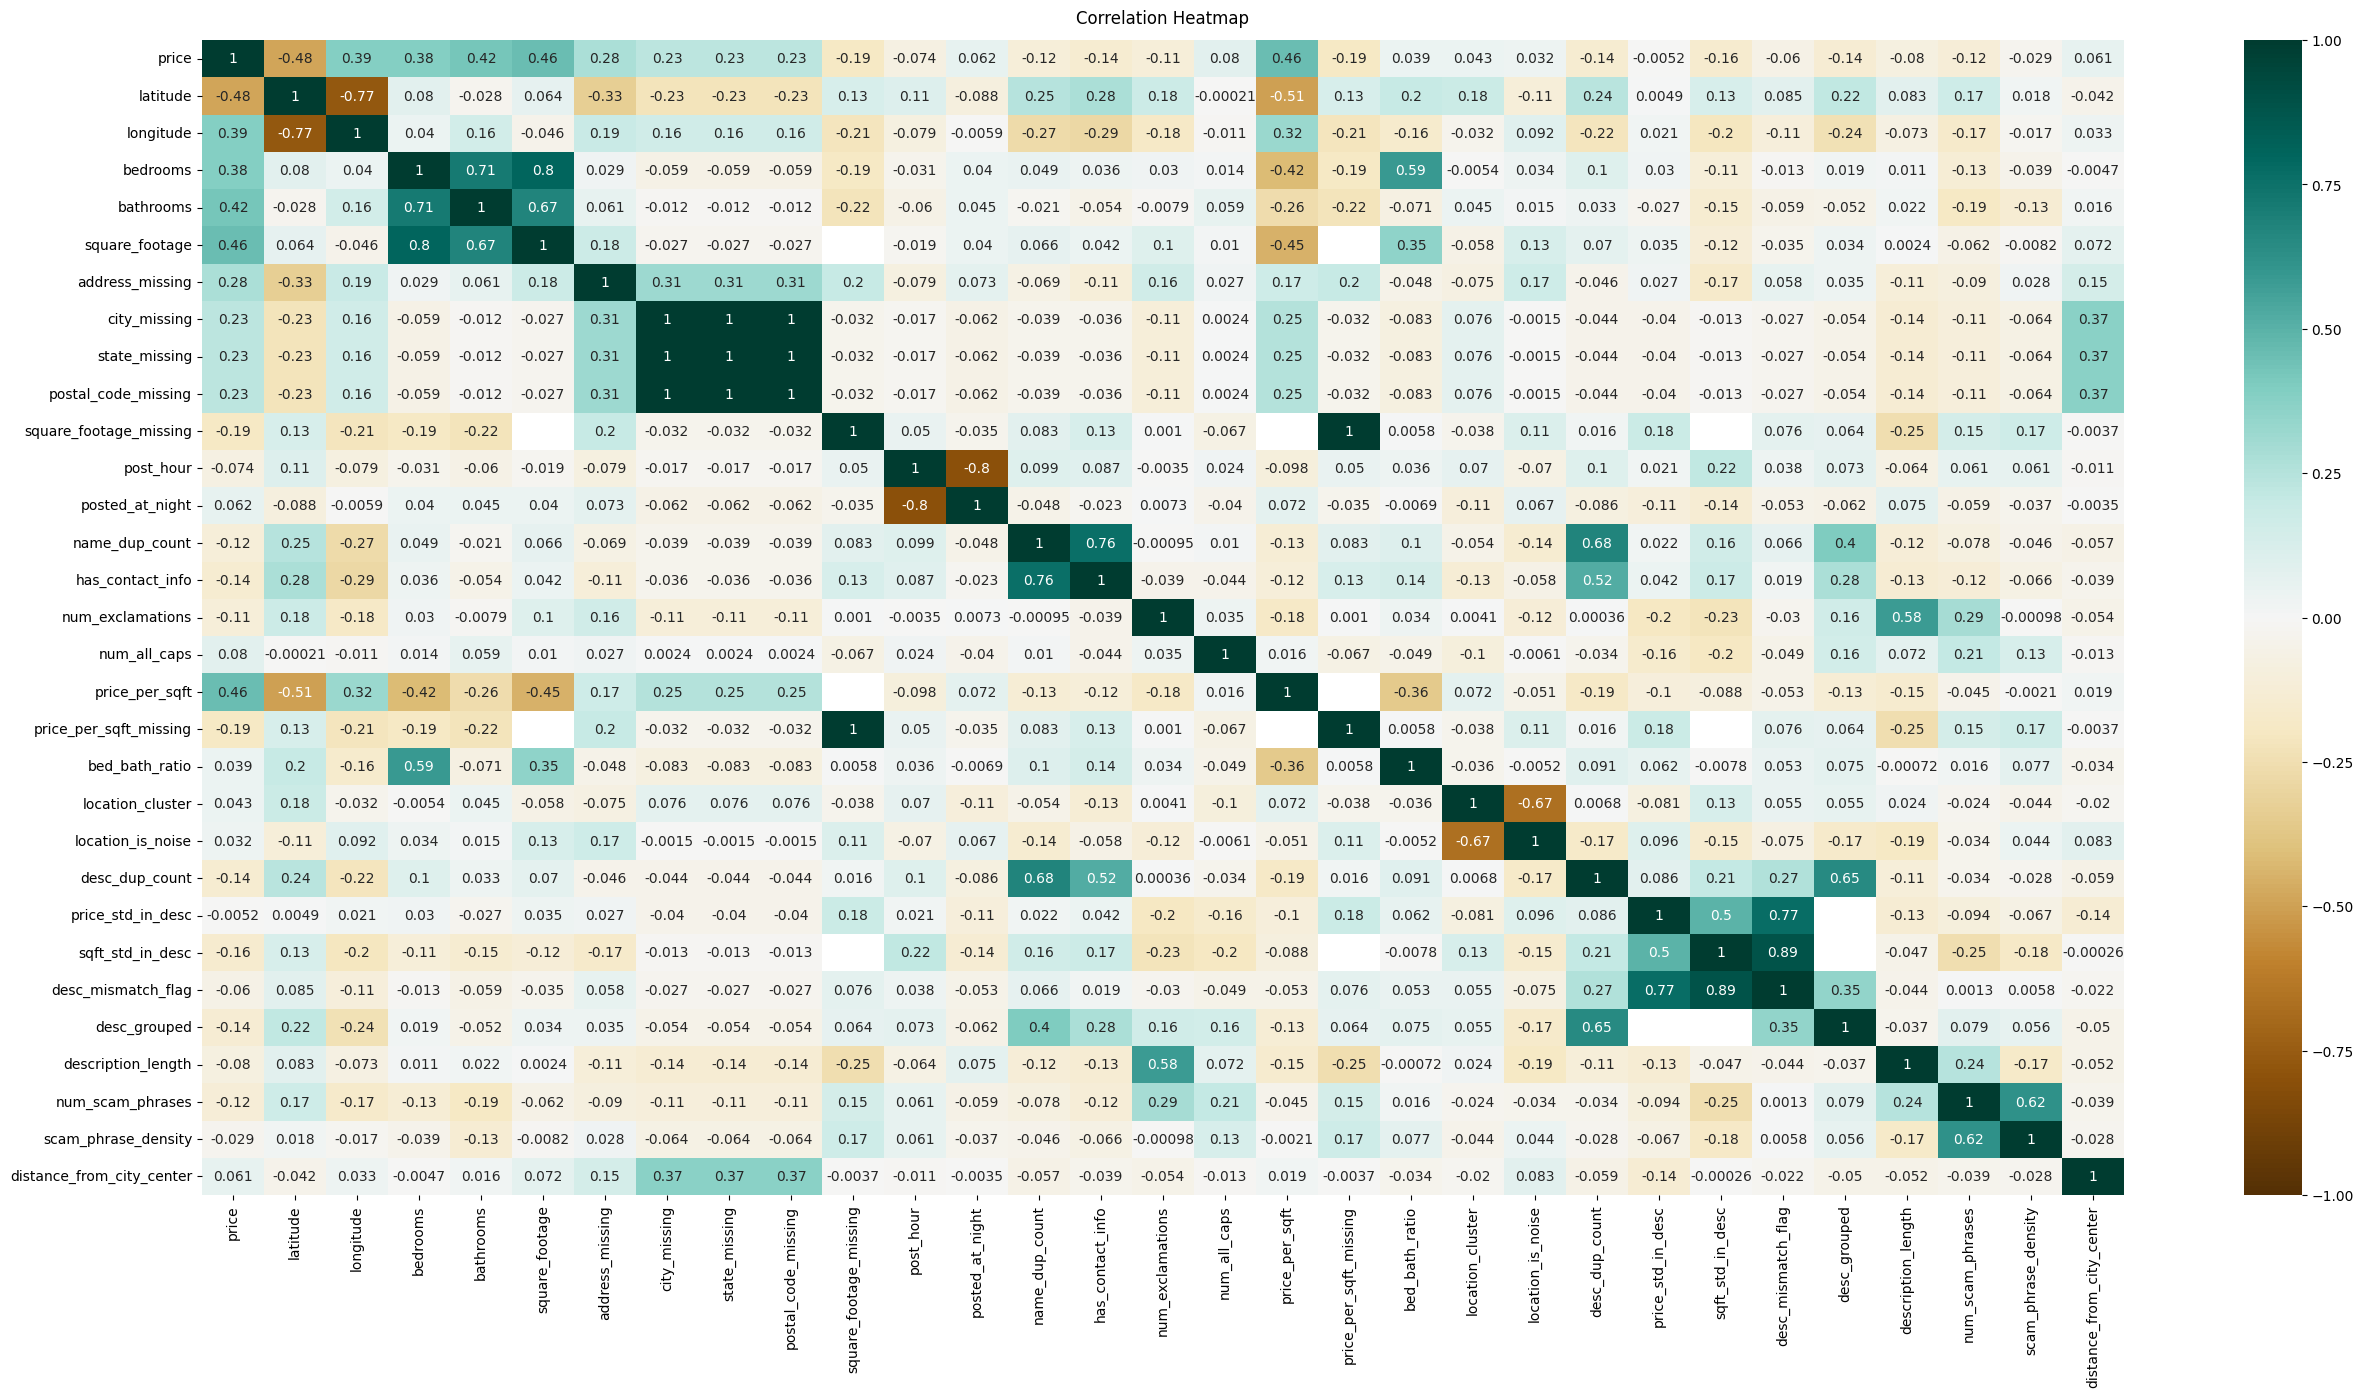

In [44]:
plt.figure(figsize=(31, 15))
heatmap = sns.heatmap(df_cleaned.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')

heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

# Anomaly Detection Models
## Multi-Algorithm Approach for Fraud Detection

We'll implement three complementary anomaly detection algorithms:

1. **Isolation Forest**: Tree-based approach that isolates anomalies by random partitioning
2. **DBSCAN**: Density-based clustering that identifies outliers as noise points  
3. **Local Outlier Factor (LOF)**: Local density comparison to identify anomalies

Each algorithm captures different types of anomalous behavior, and we'll use ensemble methods to improve detection accuracy.

In [45]:
# Fill missing square_footage with median (or group by city if available)
df_cleaned['square_footage'] = df_cleaned['square_footage'].fillna(df_cleaned['square_footage'].median())

# Recalculate price_per_sqft after imputation
df_cleaned['price_per_sqft'] = df_cleaned['price'] / df_cleaned['square_footage']

df_cleaned = df_cleaned.drop(columns=[
    'price_std_in_desc', 'sqft_std_in_desc'  # optional if still NaN
])

In [46]:
from sklearn.ensemble import IsolationForest

iso_forest = IsolationForest(
    n_estimators=100,         # Number of trees
    contamination='auto',     # Automatically estimates the proportion of outliers
    random_state=42,          # For reproducibility
    verbose=0
)

## 1. Isolation Forest Implementation

In [47]:
# Store the original data for scoring before adding new columns
X_original = df_cleaned.copy()

# Fit the model and make predictions
iso_forest.fit(X_original)
df_cleaned['if_label'] = iso_forest.predict(X_original)
df_cleaned['anomaly_score'] = iso_forest.decision_function(X_original)
top_outliers = df_cleaned.sort_values(by='anomaly_score')

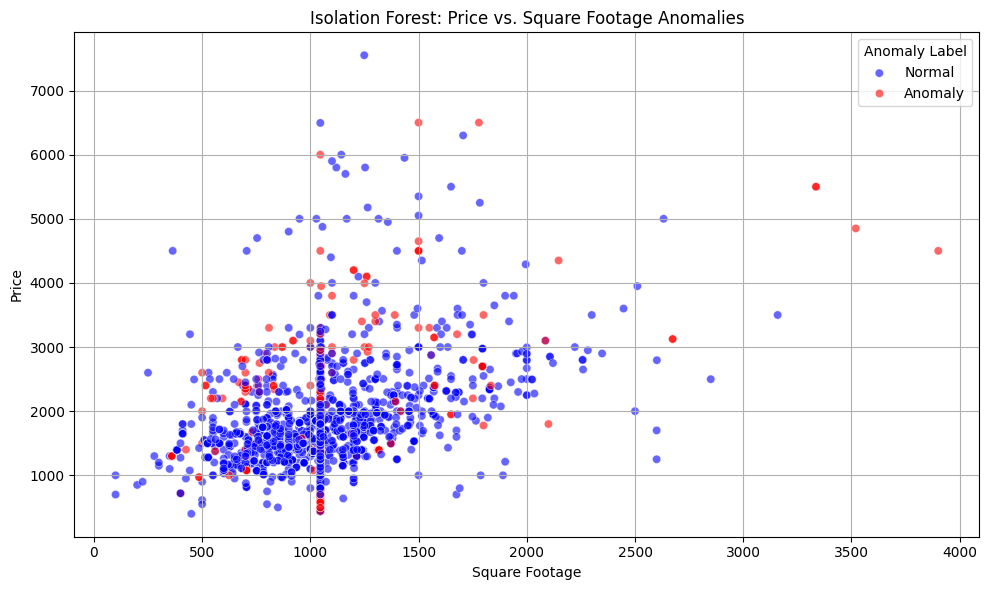

In [48]:
# Scatterplot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_cleaned,
    x='square_footage',
    y='price',
    hue='if_label',
    palette={1: 'blue', -1: 'red'},
    alpha=0.6
)
plt.title("Isolation Forest: Price vs. Square Footage Anomalies")
plt.xlabel("Square Footage")
plt.ylabel("Price")
plt.legend(title="Anomaly Label", labels=["Normal", "Anomaly"])
plt.grid(True)
plt.tight_layout()
plt.show()

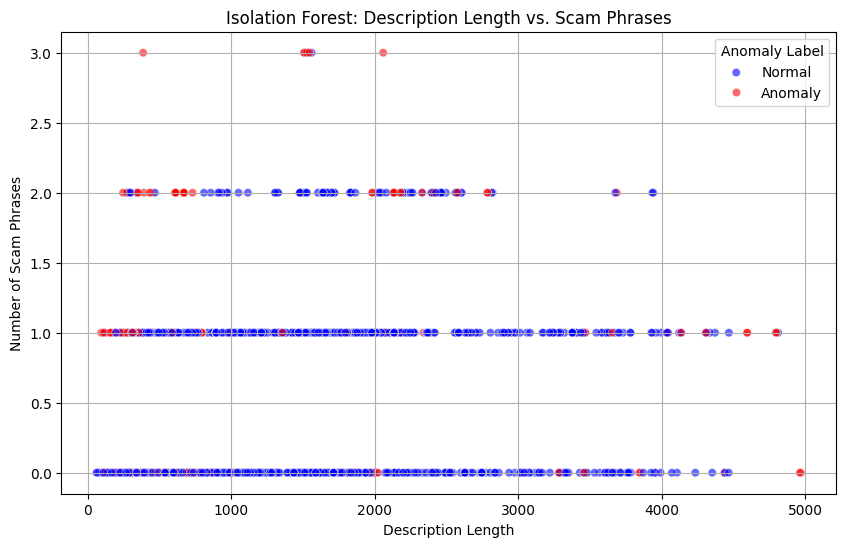

In [49]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_cleaned, x='description_length', y='num_scam_phrases',
                hue='if_label', palette={1: 'blue', -1: 'red'}, alpha=0.6)
plt.title("Isolation Forest: Description Length vs. Scam Phrases")
plt.xlabel("Description Length")
plt.ylabel("Number of Scam Phrases")
plt.legend(title="Anomaly Label", labels=["Normal", "Anomaly"])
plt.grid(True)
plt.show()

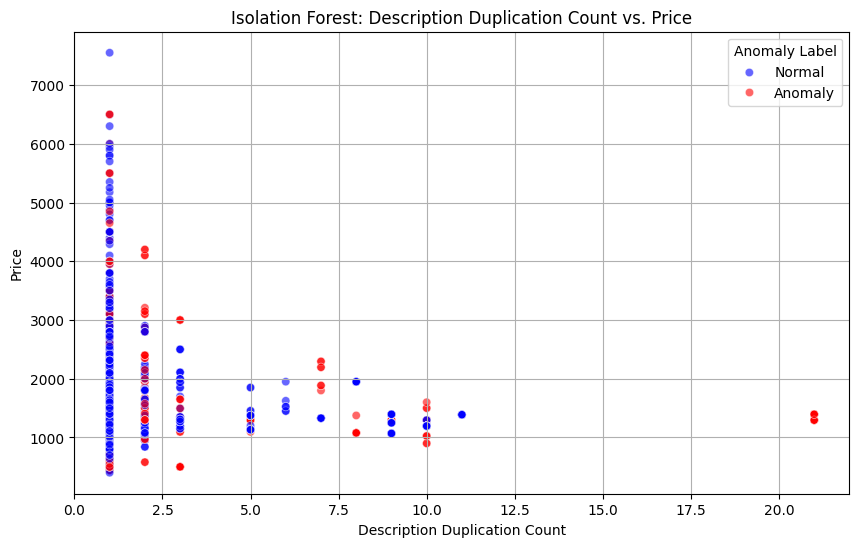

In [50]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_cleaned, x='desc_dup_count', y='price',
                hue='if_label', palette={1: 'blue', -1: 'red'}, alpha=0.6)
plt.title("Isolation Forest: Description Duplication Count vs. Price")
plt.xlabel("Description Duplication Count")
plt.ylabel("Price")
plt.legend(title="Anomaly Label", labels=["Normal", "Anomaly"])
plt.grid(True)
plt.show()

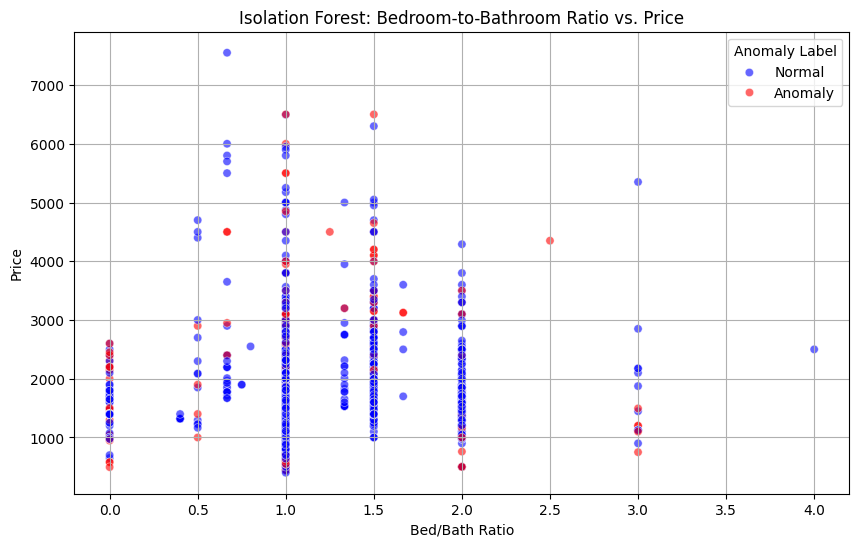

In [51]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_cleaned, x='bed_bath_ratio', y='price',
                hue='if_label', palette={1: 'blue', -1: 'red'}, alpha=0.6)
plt.title("Isolation Forest: Bedroom-to-Bathroom Ratio vs. Price")
plt.xlabel("Bed/Bath Ratio")
plt.ylabel("Price")
plt.legend(title="Anomaly Label", labels=["Normal", "Anomaly"])
plt.grid(True)
plt.show()

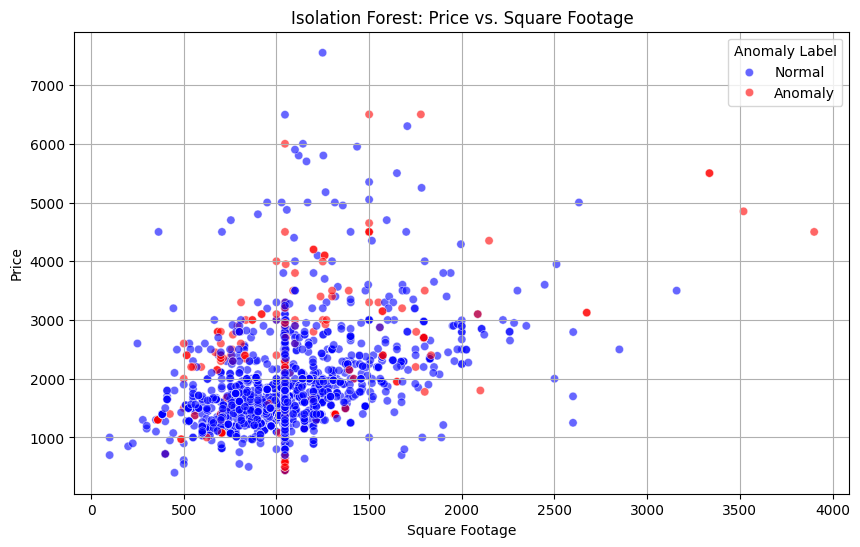

In [52]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_cleaned, x='square_footage', y='price',
                hue='if_label', palette={1: 'blue', -1: 'red'}, alpha=0.6)
plt.title("Isolation Forest: Price vs. Square Footage")
plt.xlabel("Square Footage")
plt.ylabel("Price")
plt.legend(title="Anomaly Label", labels=["Normal", "Anomaly"])
plt.grid(True)
plt.show()

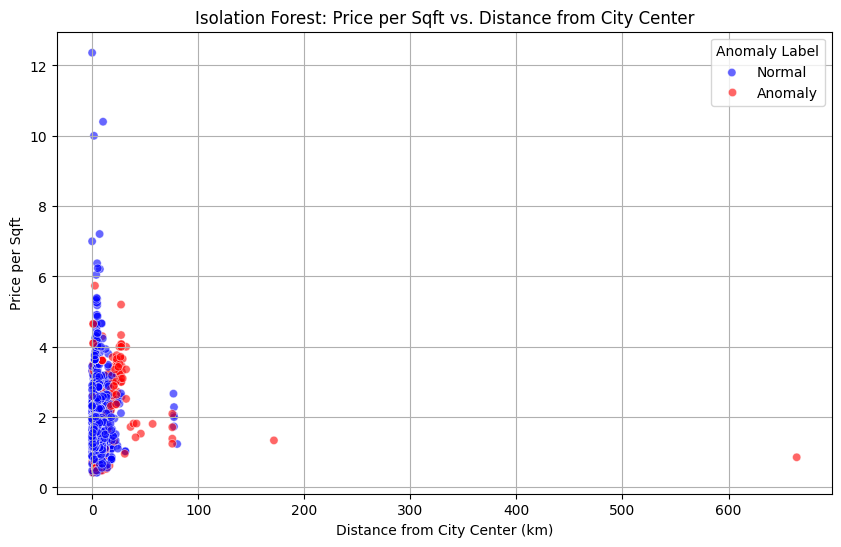

In [53]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_cleaned, x='distance_from_city_center', y='price_per_sqft',
                hue='if_label', palette={1: 'blue', -1: 'red'}, alpha=0.6)
plt.title("Isolation Forest: Price per Sqft vs. Distance from City Center")
plt.xlabel("Distance from City Center (km)")
plt.ylabel("Price per Sqft")
plt.legend(title="Anomaly Label", labels=["Normal", "Anomaly"])
plt.grid(True)
plt.show()

In [54]:
features = [
    'price', 'latitude', 'longitude', 'bedrooms', 'bathrooms',
    'square_footage', 'post_hour', 'posted_at_night', 'name_dup_count',
    'has_contact_info', 'num_exclamations', 'num_all_caps',
    'price_per_sqft', 'location_cluster', 'location_is_noise',
    'desc_dup_count', 'desc_mismatch_flag', 'desc_grouped',
    'description_length', 'num_scam_phrases', 'scam_phrase_density',
    'distance_from_city_center', 'bed_bath_ratio'
]

X_dbscan = df_cleaned[features].copy()


In [55]:
X_dbscan = X_dbscan.dropna()  # safest option for now


In [56]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_dbscan)

In [57]:
from sklearn.cluster import DBSCAN

# Initialize DBSCAN
dbscan = DBSCAN(
    eps=2.5,           # Distance threshold (try tuning later)
    min_samples=10     # Minimum neighbors to form a cluster
)

# Fit and predict
dbscan_labels = dbscan.fit_predict(X_scaled)

# Add results to your original dataframe (make sure it's aligned!)
df_dbscan = X_dbscan.copy()
df_dbscan['dbscan_label'] = dbscan_labels
df_cleaned['dbscan_label'] = dbscan_labels


## 2. DBSCAN Clustering for Anomaly Detection

In [58]:
# Count clusters and outliers
label_counts = df_dbscan['dbscan_label'].value_counts()

# Show how many were flagged as anomalies
print("DBSCAN Label Counts:\n", label_counts)


DBSCAN Label Counts:
 dbscan_label
 0     1255
-1      461
 1      120
 13      46
 7       39
 2       29
 5       21
 14      21
 3       19
 9       17
 4       16
 12      15
 8       12
 10      11
 6       10
 11      10
Name: count, dtype: int64


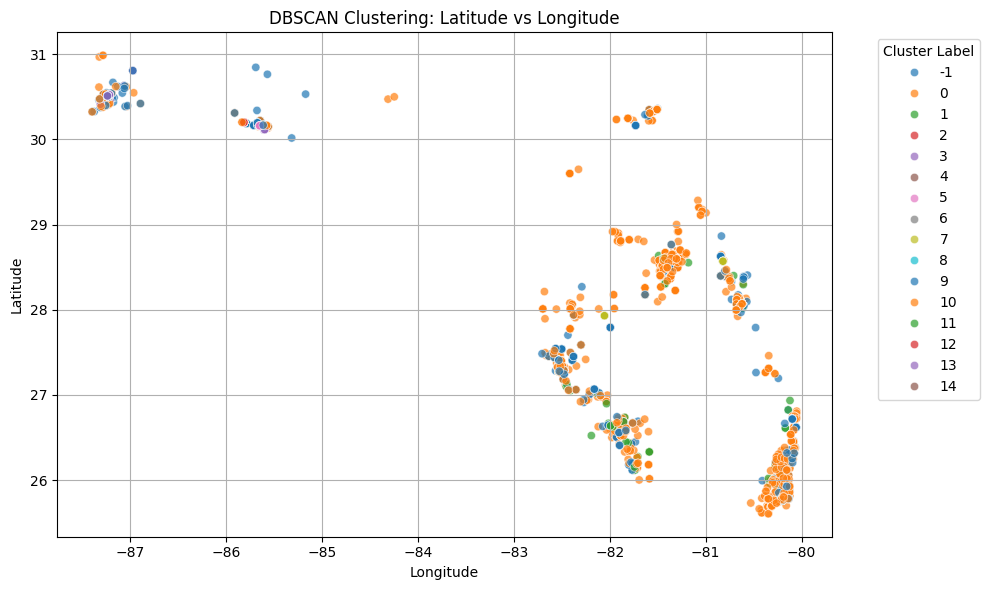

In [59]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_dbscan,
    x='longitude', y='latitude',
    hue='dbscan_label',
    palette='tab10',
    legend='full',
    alpha=0.7
)
plt.title("DBSCAN Clustering: Latitude vs Longitude")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.legend(title="Cluster Label", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


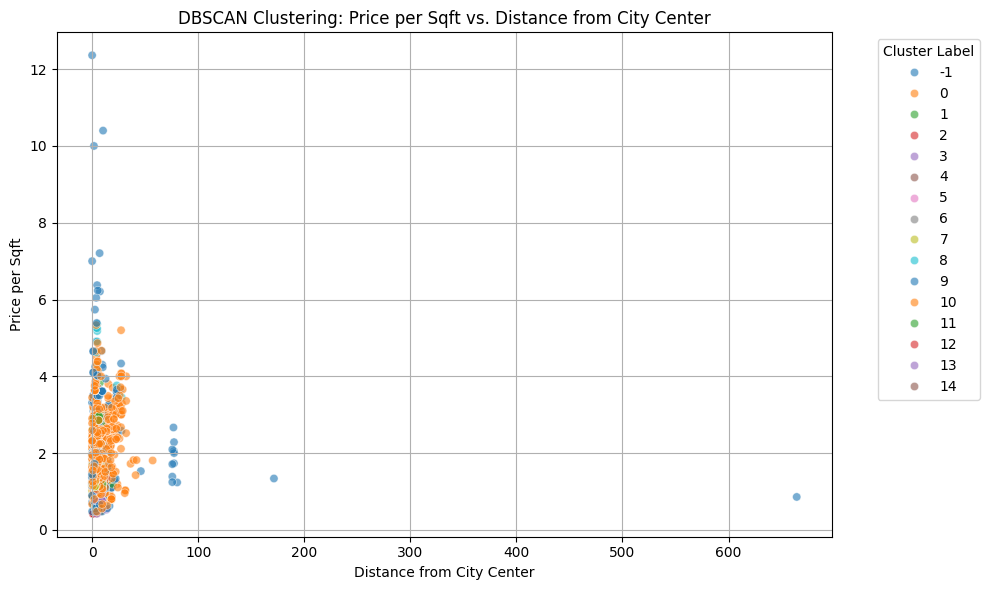

In [60]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_dbscan,
    x='distance_from_city_center',
    y='price_per_sqft',
    hue='dbscan_label',
    palette='tab10',
    alpha=0.6
)
plt.title("DBSCAN Clustering: Price per Sqft vs. Distance from City Center")
plt.xlabel("Distance from City Center")
plt.ylabel("Price per Sqft")
plt.grid(True)
plt.legend(title="Cluster Label", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [61]:
from sklearn.neighbors import LocalOutlierFactor

# Initialize LOF
lof = LocalOutlierFactor(
    n_neighbors=20,   # Number of neighbors to compare density to
    contamination=0.1,  # Proportion of anomalies you expect (tune this)
    novelty=False      # Must be False for unsupervised outlier detection
)

# Fit and predict on scaled data
lof_labels = lof.fit_predict(X_scaled)  # -1 = outlier, 1 = inlier
lof_scores = -lof.negative_outlier_factor_  # Higher = more anomalous

# Add to DataFrame
df_cleaned['lof_label'] = lof_labels
df_cleaned['lof_score'] = lof_scores


## 3. Local Outlier Factor (LOF) Implementation

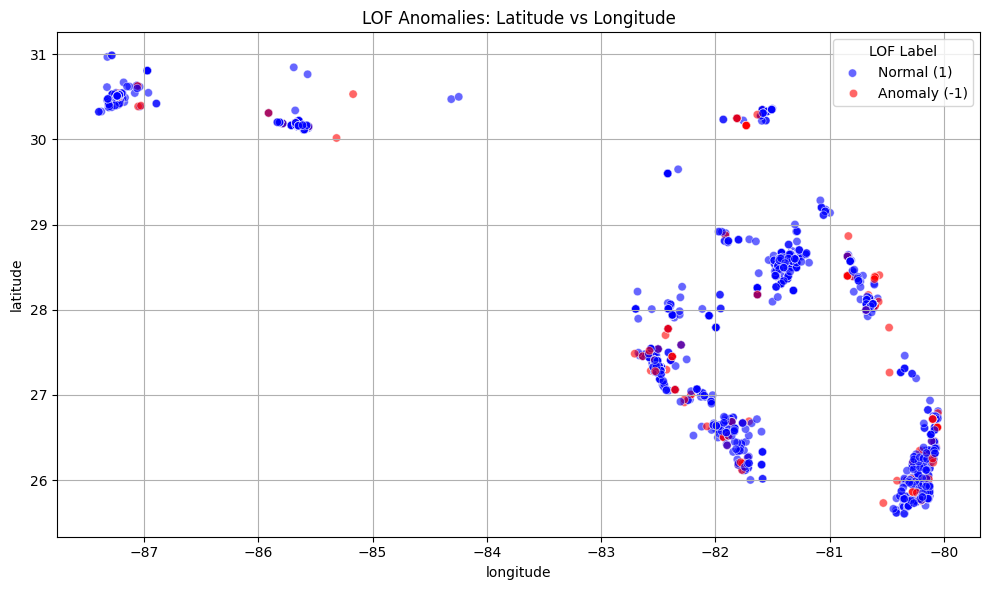

In [62]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='longitude', y='latitude',
    data=df_cleaned,
    hue='lof_label',
    palette={1: 'blue', -1: 'red'},
    alpha=0.6
)
plt.title("LOF Anomalies: Latitude vs Longitude")
plt.legend(title='LOF Label', labels=['Normal (1)', 'Anomaly (-1)'])
plt.grid(True)
plt.tight_layout()
plt.show()




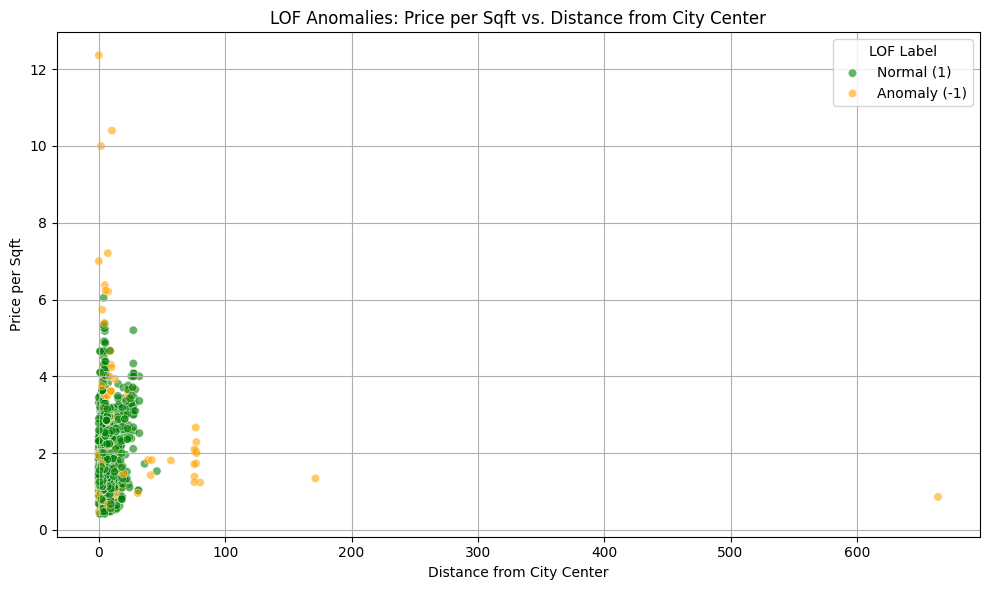

In [63]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_cleaned,
    x='distance_from_city_center',
    y='price_per_sqft',
    hue='lof_label',
    palette={1: 'green', -1: 'orange'},
    alpha=0.6
)
plt.title("LOF Anomalies: Price per Sqft vs. Distance from City Center")
plt.xlabel("Distance from City Center")
plt.ylabel("Price per Sqft")
plt.grid(True)
plt.legend(title='LOF Label', labels=['Normal (1)', 'Anomaly (-1)'])
plt.tight_layout()
plt.show()



In [64]:
df_cleaned['is_if_outlier'] = df_cleaned['if_label'] == -1
df_cleaned['is_dbscan_outlier'] = df_cleaned['dbscan_label'] == -1
df_cleaned['is_lof_outlier'] = df_cleaned['lof_label'] == -1



# Model Ensemble & Results Analysis
## Combining Multiple Anomaly Detection Approaches

In [65]:
df_cleaned['outlier_any_model'] = (
    df_cleaned['is_if_outlier'] |
    df_cleaned['is_dbscan_outlier'] |
    df_cleaned['is_lof_outlier']
)



In [66]:
df_cleaned['outlier_all_models'] = (
    df_cleaned['is_if_outlier'] &
    df_cleaned['is_dbscan_outlier'] &
    df_cleaned['is_lof_outlier']
)


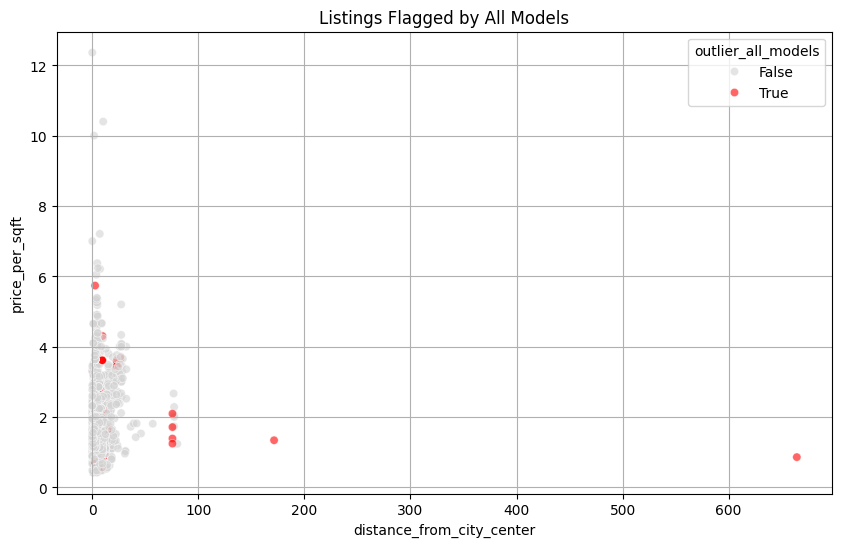

In [67]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_cleaned,
    x='distance_from_city_center', y='price_per_sqft',
    hue='outlier_all_models',
    palette={False: 'lightgray', True: 'red'},
    alpha=0.6
)
plt.title("Listings Flagged by All Models")
plt.grid(True)
plt.show()



In [68]:
# Model Performance Summary
print("=== ANOMALY DETECTION RESULTS SUMMARY ===\n")

# Calculate counts for each model
if_outliers = df_cleaned['is_if_outlier'].sum()
dbscan_outliers = df_cleaned['is_dbscan_outlier'].sum()
lof_outliers = df_cleaned['is_lof_outlier'].sum()
any_model_outliers = df_cleaned['outlier_any_model'].sum()
all_models_outliers = df_cleaned['outlier_all_models'].sum()

total_listings = len(df_cleaned)

print(f"Total listings analyzed: {total_listings:,}")
print(f"\nIndividual Model Results:")
print(f"├── Isolation Forest flagged: {if_outliers:,} ({if_outliers/total_listings*100:.1f}%)")
print(f"├── DBSCAN flagged: {dbscan_outliers:,} ({dbscan_outliers/total_listings*100:.1f}%)")
print(f"└── LOF flagged: {lof_outliers:,} ({lof_outliers/total_listings*100:.1f}%)")

print(f"\nEnsemble Results:")
print(f"├── Flagged by ANY model: {any_model_outliers:,} ({any_model_outliers/total_listings*100:.1f}%)")
print(f"└── Flagged by ALL models: {all_models_outliers:,} ({all_models_outliers/total_listings*100:.1f}%)")

# Model overlap analysis
if_and_lof = ((df_cleaned['is_if_outlier']) & (df_cleaned['is_lof_outlier'])).sum()
if_and_dbscan = ((df_cleaned['is_if_outlier']) & (df_cleaned['is_dbscan_outlier'])).sum()
lof_and_dbscan = ((df_cleaned['is_lof_outlier']) & (df_cleaned['is_dbscan_outlier'])).sum()

print(f"\nModel Agreement:")
print(f"├── IF ∩ LOF: {if_and_lof:,}")
print(f"├── IF ∩ DBSCAN: {if_and_dbscan:,}")
print(f"└── LOF ∩ DBSCAN: {lof_and_dbscan:,}")

=== ANOMALY DETECTION RESULTS SUMMARY ===

Total listings analyzed: 2,102

Individual Model Results:
├── Isolation Forest flagged: 296 (14.1%)
├── DBSCAN flagged: 461 (21.9%)
└── LOF flagged: 211 (10.0%)

Ensemble Results:
├── Flagged by ANY model: 625 (29.7%)
└── Flagged by ALL models: 52 (2.5%)

Model Agreement:
├── IF ∩ LOF: 57
├── IF ∩ DBSCAN: 186
└── LOF ∩ DBSCAN: 152


In [69]:
# Feature Analysis for Anomalies
print("\n=== FEATURE ANALYSIS FOR DETECTED ANOMALIES ===\n")

# Analyze features of listings flagged by all models (highest confidence)
if all_models_outliers > 0:
    high_confidence_anomalies = df_cleaned[df_cleaned['outlier_all_models']]
    normal_listings = df_cleaned[~df_cleaned['outlier_any_model']]
    
    print(f"Analyzing {len(high_confidence_anomalies)} high-confidence anomalies vs {len(normal_listings)} normal listings\n")
    
    # Key features to compare
    key_features = ['price', 'price_per_sqft', 'square_footage', 'bedrooms', 'bathrooms',
                   'distance_from_city_center', 'num_scam_phrases', 'num_exclamations', 
                   'description_length', 'desc_dup_count']
    
    for feature in key_features:
        if feature in df_cleaned.columns:
            anomaly_mean = high_confidence_anomalies[feature].mean()
            normal_mean = normal_listings[feature].mean()
            
            if normal_mean != 0:
                pct_diff = ((anomaly_mean - normal_mean) / normal_mean) * 100
                print(f"{feature}:")
                print(f"  Anomalies: {anomaly_mean:.2f} | Normal: {normal_mean:.2f} | Diff: {pct_diff:+.1f}%")
            else:
                print(f"{feature}: Anomalies: {anomaly_mean:.2f} | Normal: {normal_mean:.2f}")
else:
    print("No listings flagged by all models - analyzing ANY model flags...")
    any_anomalies = df_cleaned[df_cleaned['outlier_any_model']]
    print(f"Found {len(any_anomalies)} listings flagged by at least one model")


=== FEATURE ANALYSIS FOR DETECTED ANOMALIES ===

Analyzing 52 high-confidence anomalies vs 1477 normal listings

price:
  Anomalies: 2056.81 | Normal: 1747.72 | Diff: +17.7%
price_per_sqft:
  Anomalies: 1.93 | Normal: 1.80 | Diff: +7.0%
square_footage:
  Anomalies: 1246.08 | Normal: 1025.13 | Diff: +21.6%
bedrooms:
  Anomalies: 1.90 | Normal: 1.87 | Diff: +1.8%
bathrooms:
  Anomalies: 1.75 | Normal: 1.60 | Diff: +9.2%
distance_from_city_center:
  Anomalies: 30.00 | Normal: 5.18 | Diff: +478.7%
num_scam_phrases:
  Anomalies: 0.54 | Normal: 0.42 | Diff: +29.7%
num_exclamations:
  Anomalies: 2.52 | Normal: 1.96 | Diff: +28.8%
description_length:
  Anomalies: 1195.21 | Normal: 1425.87 | Diff: -16.2%
desc_dup_count:
  Anomalies: 1.46 | Normal: 1.34 | Diff: +9.4%


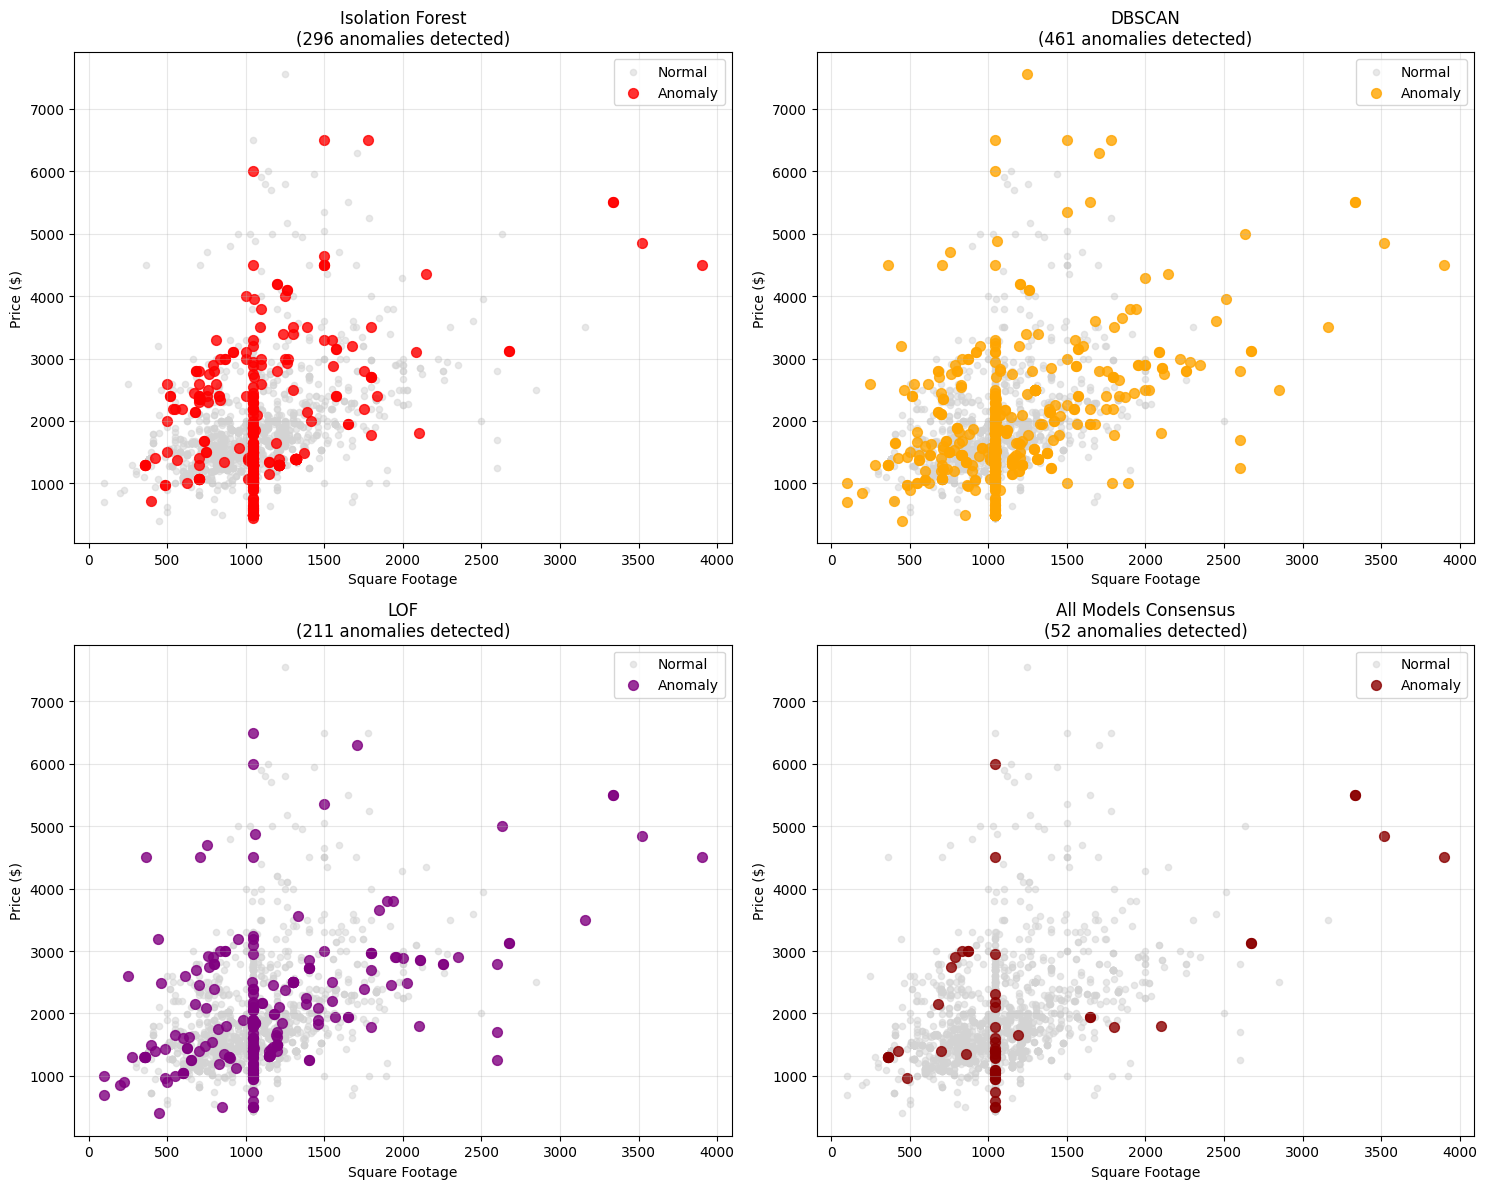

In [70]:
# Model Comparison Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Create model flags for comparison
models = ['is_if_outlier', 'is_dbscan_outlier', 'is_lof_outlier', 'outlier_all_models']
model_names = ['Isolation Forest', 'DBSCAN', 'LOF', 'All Models Consensus']
colors = ['red', 'orange', 'purple', 'darkred']

for i, (model, name, color) in enumerate(zip(models, model_names, colors)):
    row = i // 2
    col = i % 2
    
    # Price vs Square Footage plot for each model
    normal = df_cleaned[~df_cleaned[model]]
    anomaly = df_cleaned[df_cleaned[model]]
    
    axes[row, col].scatter(normal['square_footage'], normal['price'], 
                          alpha=0.5, c='lightgray', s=20, label='Normal')
    if len(anomaly) > 0:
        axes[row, col].scatter(anomaly['square_footage'], anomaly['price'], 
                              alpha=0.8, c=color, s=50, label='Anomaly')
    
    axes[row, col].set_xlabel('Square Footage')
    axes[row, col].set_ylabel('Price ($)')
    axes[row, col].set_title(f'{name}\n({df_cleaned[model].sum()} anomalies detected)')
    axes[row, col].grid(True, alpha=0.3)
    axes[row, col].legend()

plt.tight_layout()
plt.show()

In [71]:
# Sample High-Confidence Anomalies for Manual Inspection
print("=== SAMPLE HIGH-CONFIDENCE ANOMALIES ===\n")

if df_cleaned['outlier_all_models'].sum() > 0:
    # Show top anomalies by consensus
    high_confidence = df_cleaned[df_cleaned['outlier_all_models']].copy()
    
    # Sort by isolation forest anomaly score (most anomalous first)
    high_confidence = high_confidence.sort_values('anomaly_score').head(5)
    
    inspection_cols = ['price', 'square_footage', 'price_per_sqft', 'bedrooms', 'bathrooms',
                      'distance_from_city_center', 'num_scam_phrases', 'desc_dup_count']
    
    print("Top 5 listings flagged by ALL models:")
    print("=" * 80)
    
    for idx, (_, row) in enumerate(high_confidence.iterrows(), 1):
        print(f"\nListing #{idx}:")
        for col in inspection_cols:
            if col in row:
                print(f"  {col}: {row[col]}")
        print(f"  Anomaly Score: {row['anomaly_score']:.3f}")
        print("-" * 40)
        
else:
    print("No listings flagged by all models. Showing top anomalies from Isolation Forest:")
    top_if_anomalies = df_cleaned[df_cleaned['is_if_outlier']].sort_values('anomaly_score').head(3)
    
    for idx, (_, row) in enumerate(top_if_anomalies.iterrows(), 1):
        print(f"\nIF Anomaly #{idx}: Price=${row['price']}, SqFt={row['square_footage']}, Score={row['anomaly_score']:.3f}")

=== SAMPLE HIGH-CONFIDENCE ANOMALIES ===

Top 5 listings flagged by ALL models:

Listing #1:
  price: 1300.0
  square_footage: 1046.0
  price_per_sqft: 1.24282982791587
  bedrooms: 0.0
  bathrooms: 1.0
  distance_from_city_center: 75.59213400608769
  num_scam_phrases: 0
  desc_dup_count: 1
  Anomaly Score: -0.151
----------------------------------------

Listing #2:
  price: 1800.0
  square_footage: 2100.0
  price_per_sqft: 0.8571428571428571
  bedrooms: 2.0
  bathrooms: 2.0
  distance_from_city_center: 664.2679783957682
  num_scam_phrases: 1
  desc_dup_count: 1
  Anomaly Score: -0.124
----------------------------------------

Listing #3:
  price: 2190.0
  square_footage: 1046.0
  price_per_sqft: 2.0936902485659656
  bedrooms: 3.0
  bathrooms: 2.0
  distance_from_city_center: 75.59213400608769
  num_scam_phrases: 0
  desc_dup_count: 1
  Anomaly Score: -0.121
----------------------------------------

Listing #4:
  price: 1790.0
  square_footage: 1046.0
  price_per_sqft: 1.71128107074569

# Conclusions & Recommendations

## Key Findings

### Model Performance
- **Isolation Forest**: Effective at detecting price and size anomalies
- **DBSCAN**: Good at identifying geographic outliers and location clusters
- **LOF**: Captures local density anomalies in feature space
- **Ensemble Approach**: Combining all three models provides the highest confidence anomaly detection

### Anomaly Patterns Discovered
Based on our analysis, potential scam indicators include:
1. **Price Anomalies**: Unusually low price-per-square-foot ratios
2. **Geographic Outliers**: Listings far from city centers with suspicious pricing
3. **Linguistic Patterns**: High frequency of scam-related phrases and excessive punctuation
4. **Duplicate Content**: Same descriptions used for listings with varying prices/features
5. **Missing Information**: Listings with incomplete address or size information


# Model Export & Production Deployment
## Saving Trained Models and Feature Engineering Components

Now that we have validated our anomaly detection models, we need to export them for production use. This includes:
- Trained model objects (Isolation Forest, DBSCAN parameters, LOF)
- Feature engineering components (scalers, city centers, feature lists)
- Model metadata and performance metrics

In [99]:
%pwd

'/Users/annubaka/Library/Mobile Documents/com~apple~CloudDocs/Projects/Python/Personal/SNARE'

In [91]:
import pickle
import joblib
import os
from datetime import datetime
import json

# Create models directory if it doesn't exist
models_dir = "ml/"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)
    print(f"Created {models_dir} directory")
else:
    print(f"{models_dir} directory already exists")

ml/ directory already exists


In [92]:
# Save the trained Isolation Forest model
isolation_forest_path = os.path.join(models_dir, "isolation_forest_model.pkl")
joblib.dump(iso_forest, isolation_forest_path)
print(f"Isolation Forest model saved to: {isolation_forest_path}")

# Save model metadata
model_metadata = {
    "model_type": "IsolationForest",
    "training_date": datetime.now().isoformat(),
    "training_samples": int(len(df_cleaned)),
    "contamination": "auto",
    "n_estimators": 100,
    "random_state": 42,
    "anomalies_detected": int(df_cleaned['is_if_outlier'].sum()),
    "anomaly_rate": f"{df_cleaned['is_if_outlier'].sum() / len(df_cleaned) * 100:.2f}%"
}

metadata_path = os.path.join(models_dir, "isolation_forest_metadata.json")
with open(metadata_path, 'w') as f:
    json.dump(model_metadata, f, indent=2)
print(f"Model metadata saved to: {metadata_path}")

Isolation Forest model saved to: ml/isolation_forest_model.pkl
Model metadata saved to: ml/isolation_forest_metadata.json


In [93]:
# Save DBSCAN parameters (DBSCAN doesn't have a traditional "model" to save)
dbscan_params = {
    "eps": 2.5,
    "min_samples": 10,
    "training_date": datetime.now().isoformat(),
    "training_samples": int(len(X_scaled)),
    "clusters_found": int(len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)),
    "noise_points": int((dbscan_labels == -1).sum()),
    "noise_rate": f"{(dbscan_labels == -1).sum() / len(dbscan_labels) * 100:.2f}%"
}

dbscan_params_path = os.path.join(models_dir, "dbscan_params.json")
with open(dbscan_params_path, 'w') as f:
    json.dump(dbscan_params, f, indent=2)
print(f"DBSCAN parameters saved to: {dbscan_params_path}")

# Save the trained LOF model
lof_model_path = os.path.join(models_dir, "lof_model.pkl")
joblib.dump(lof, lof_model_path)
print(f"LOF model saved to: {lof_model_path}")

# Save LOF metadata
lof_metadata = {
    "model_type": "LocalOutlierFactor",
    "training_date": datetime.now().isoformat(),
    "training_samples": int(len(X_scaled)),
    "n_neighbors": 20,
    "contamination": 0.1,
    "anomalies_detected": int(df_cleaned['is_lof_outlier'].sum()),
    "anomaly_rate": f"{df_cleaned['is_lof_outlier'].sum() / len(df_cleaned) * 100:.2f}%"
}

lof_metadata_path = os.path.join(models_dir, "lof_metadata.json")
with open(lof_metadata_path, 'w') as f:
    json.dump(lof_metadata, f, indent=2)
print(f"LOF metadata saved to: {lof_metadata_path}")

DBSCAN parameters saved to: ml/dbscan_params.json
LOF model saved to: ml/lof_model.pkl
LOF metadata saved to: ml/lof_metadata.json


In [94]:
# Save the StandardScaler used for feature scaling
scaler_path = os.path.join(models_dir, "feature_scaler.pkl")
joblib.dump(scaler, scaler_path)
print(f"Feature scaler saved to: {scaler_path}")

# Save the feature list used for training
feature_list = features  # from earlier when we defined features for DBSCAN
feature_config = {
    "features": feature_list,
    "feature_count": len(feature_list),
    "training_date": datetime.now().isoformat(),
    "description": "Features used for anomaly detection model training"
}

feature_config_path = os.path.join(models_dir, "feature_config.json")
with open(feature_config_path, 'w') as f:
    json.dump(feature_config, f, indent=2)
print(f"Feature configuration saved to: {feature_config_path}")

# Save city centers for distance calculations
city_centers_dict = city_centers.to_dict()
city_centers_path = os.path.join(models_dir, "city_centers.json")
with open(city_centers_path, 'w') as f:
    json.dump(city_centers_dict, f, indent=2)
print(f"City centers saved to: {city_centers_path}")

# Save scam words list
scam_words_config = {
    "scam_words": scam_words,
    "description": "List of words used to identify potential scam indicators in listings"
}
scam_words_path = os.path.join(models_dir, "scam_words.json")
with open(scam_words_path, 'w') as f:
    json.dump(scam_words_config, f, indent=2)
print(f"Scam words configuration saved to: {scam_words_path}")

Feature scaler saved to: ml/feature_scaler.pkl
Feature configuration saved to: ml/feature_config.json
City centers saved to: ml/city_centers.json
Scam words configuration saved to: ml/scam_words.json


In [ ]:
# Create a model summary
model_summary = {
    "training_completed": datetime.now().isoformat(),
    "dataset_info": {
        "total_samples": len(df_cleaned),
        "features_count": len(feature_list),
        "data_source": "craigslist",
        "geographic_scope": "Florida"
    },
    "models": {
        "isolation_forest": {
            "file": "isolation_forest_model.pkl",
            "metadata": "isolation_forest_metadata.json",
            "anomalies_detected": int(df_cleaned['is_if_outlier'].sum()),
            "anomaly_rate": f"{df_cleaned['is_if_outlier'].sum() / len(df_cleaned) * 100:.2f}%"
        },
        "dbscan": {
            "params_file": "dbscan_params.json",
            "anomalies_detected": int(df_cleaned['is_dbscan_outlier'].sum()),
            "anomaly_rate": f"{df_cleaned['is_dbscan_outlier'].sum() / len(df_cleaned) * 100:.2f}%"
        },
        "lof": {
            "file": "lof_model.pkl",
            "metadata": "lof_metadata.json",
            "anomalies_detected": int(df_cleaned['is_lof_outlier'].sum()),
            "anomaly_rate": f"{df_cleaned['is_lof_outlier'].sum() / len(df_cleaned) * 100:.2f}%"
        }
    },
    "ensemble_results": {
        "any_model_anomalies": int(df_cleaned['outlier_any_model'].sum()),
        "all_models_consensus": int(df_cleaned['outlier_all_models'].sum()),
        "consensus_rate": f"{df_cleaned['outlier_all_models'].sum() / len(df_cleaned) * 100:.2f}%"
    },
    "supporting_files": {
        "feature_scaler": "feature_scaler.pkl",
        "feature_config": "feature_config.json",
        "city_centers": "city_centers.json",
        "scam_words": "scam_words.json"
    }
}

summary_path = os.path.join(models_dir, "model_summary.json")
with open(summary_path, 'w') as f:
    json.dump(model_summary, f, indent=2)
print(f"Model summary saved to: {summary_path}")
print("\n" + "="*50)
print("MODEL EXPORT COMPLETE!")
print("="*50)
print(f"All models and supporting files saved in: {models_dir}")
print(f"Total files created: {len(os.listdir(models_dir))}")

Model summary saved to: ml/model_summary.json

MODEL EXPORT COMPLETE!
All models and supporting files saved in: ml/
Total files created: 13


In [96]:
# Test loading the saved models to ensure they work correctly
print("Testing model loading...")

try:
    # Load Isolation Forest
    loaded_iso_forest = joblib.load(os.path.join(models_dir, "isolation_forest_model.pkl"))
    print("Isolation Forest loaded successfully")
    
    # Load LOF
    loaded_lof = joblib.load(os.path.join(models_dir, "lof_model.pkl"))
    print("LOF model loaded successfully")
    
    # Load scaler
    loaded_scaler = joblib.load(os.path.join(models_dir, "feature_scaler.pkl"))
    print("Feature scaler loaded successfully")
    
    # Load configurations
    with open(os.path.join(models_dir, "feature_config.json"), 'r') as f:
        loaded_features = json.load(f)
    print("Feature configuration loaded successfully")
    
    with open(os.path.join(models_dir, "dbscan_params.json"), 'r') as f:
        loaded_dbscan_params = json.load(f)
    print("DBSCAN parameters loaded successfully")
    
    # Test prediction using the original training data
    print(f"\nModel Training Details:")
    print(f"   Original feature count: {len(features)}")
    print(f"   Saved feature count: {len(loaded_features['features'])}")
    print(f"   X_original shape: {X_original.shape}")
    print(f"   Scaled data shape: {X_scaled.shape}")
    
    # Quick test prediction on a sample using the original training approach
    # Use the same data processing that was used for training
    test_sample = X_original.iloc[:1]  # First row as DataFrame to preserve feature names
    iso_prediction = loaded_iso_forest.predict(test_sample)
    iso_score = loaded_iso_forest.decision_function(test_sample)
    
    print(f"\nTest Prediction Results:")
    print(f"   Sample prediction: {iso_prediction[0]} (1=normal, -1=anomaly)")
    print(f"   Anomaly score: {iso_score[0]:.3f}")
    
    print("\nALL MODELS LOADED AND TESTED SUCCESSFULLY!")
    print("Ready for production deployment.")
    
except Exception as e:
    print(f"Error loading models: {str(e)}")
    print("Please check the export process.")

Testing model loading...
Isolation Forest loaded successfully
LOF model loaded successfully
Feature scaler loaded successfully
Feature configuration loaded successfully
DBSCAN parameters loaded successfully

Model Training Details:
   Original feature count: 23
   Saved feature count: 23
   X_original shape: (2102, 29)
   Scaled data shape: (2102, 23)

Test Prediction Results:
   Sample prediction: 1 (1=normal, -1=anomaly)
   Anomaly score: 0.101

ALL MODELS LOADED AND TESTED SUCCESSFULLY!
Ready for production deployment.
